In [ ]:
!pip install transformers datasets wandb

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/NLP_Project_1")
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

fine_tuned_model_name = "to_delete"

In [ ]:
!wandb login

import wandb
wandb.init(project = "Goorm_1st_project", entity = "2nd_group", name = fine_tuned_model_name)

In [ ]:
import pandas as pd
import torch
import datasets
import gc
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import utils

from imblearn.over_sampling import RandomOverSampler
from torch.nn.utils.rnn import pad_sequence
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from collections import deque
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoConfig,  Adafactor, get_cosine_schedule_with_warmup
from transformers import XLNetForSequenceClassification, BertForSequenceClassification, RobertaForSequenceClassification, AlbertForSequenceClassification
SEED = 20220719
BACKBONE_NAME = "bert-base-uncased"

# 아래는 원활한 실험을 위해 random state를 고정하는 코드입니다.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

tokenizer = AutoTokenizer.from_pretrained(BACKBONE_NAME)
tokenizer.add_tokens("_num_")

model_config = AutoConfig.from_pretrained(BACKBONE_NAME)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

In [4]:
dataset = utils.load_data("./RawData", 8, 22, tokenizer)
original_train = dataset["train"]
original_valid = dataset["valid"]

# 아래는 전처리 코드입니다. 
# original_train.loc[:, "sentence"] = original_train.loc[:, "sentence"].apply(lambda x : cleaning(x))
# original_valid.loc[:, "sentence"] = original_valid.loc[:, "sentence"].apply(lambda x : cleaning(x))

# original_train = original_train.loc[original_train["sentence"].str.len() > 17, :]
# original_valid = original_valid.loc[original_valid["sentence"].str.len() > 17, :]

In [ ]:
batch_size = 512
collator = DataCollatorWithPadding(tokenizer, return_tensors = "pt")

train_data = utils.get_dataset(original_train, tokenizer, collator, batch_size, True)
valid_data = utils.get_dataset(original_valid, tokenizer, collator, batch_size, True)

In [ ]:
learning_rate = 0.00007514 # from wandb sweep
epochs = 3

model = BertForSequenceClassification.from_pretrained(BACKBONE_NAME,
                                                        num_labels = 2,
                                                        ignore_mismatched_sizes = True)
model.resize_token_embeddings(len(tokenizer))
model.train()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, eps = 1e-6, weight_decay = 0.02)

lr_scheduler = get_cosine_schedule_with_warmup(optimizer = optimizer,
                                               num_warmup_steps = int(len(train_data) * epochs * 0.06),
                                               num_training_steps = len(train_data) * epochs)

In [ ]:
wandb_config = {
    "learning_rate" : learning_rate,
    "batch_size" : batch_size,
    "backbone" : BACKBONE_NAME,
    "epochs" : epochs
}

wandb.config.update(wandb_config)

In [ ]:
def accuracy(pred, true) :
    pred = pred.softmax(1)
    pred = pred.argmax(1)
    return pred.eq(true).sum() / len(pred)

In [ ]:
scaler = torch.cuda.amp.GradScaler()
wandb.watch(model, log = "all", log_freq = 10)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing = 0.1)

for epoch in range(epochs) :
    cum_loss = deque(maxlen = 20)
    cum_acc = deque(maxlen = 20)

    curr_loss = []
    curr_acc = []

    with tqdm(train_data, unit = " batch") as tepoch :
        curr_loss.clear()
        curr_acc.clear()
        model.train()
        for i, batch in enumerate(tepoch) :
            optimizer.zero_grad()

            tepoch.set_description(f"Train Epoch {epoch}")
            label = batch["labels"].to(device)
            batch = {k : v.to(device) for k, v in batch.items()}
            
            with torch.cuda.amp.autocast() :
              outputs = model(**batch)
              loss = loss_fn(outputs['logits'], label)

            logits = outputs["logits"]

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()

            acc = accuracy(logits, label)
            
            cum_loss.append(float(loss))
            cum_acc.append(float(acc))
            curr_loss.append(float(loss))
            curr_acc.append(float(acc))
            tepoch.set_postfix(loss = sum(cum_loss) / len(cum_loss),
                               accuracy = sum(cum_acc) / len(cum_acc))
            
            wandb.log({"loss" : sum(cum_loss) / len(cum_loss),
                        "acc" : sum(cum_acc) / len(cum_acc),
                        "lr" : optimizer.state_dict()["param_groups"][0]['lr']})

        print("Train loss : ", sum(curr_loss) / len(curr_loss))
        print("Train acc :", sum(curr_acc) / len(curr_acc))
        
    curr_loss.clear()
    curr_acc.clear()

    with tqdm(valid_data, unit = " batch") as tepoch :
        model.eval()
        with torch.no_grad() :
            for i, batch in enumerate(tepoch) :
                tepoch.set_description(f"Valid Epoch {epoch}")
                label = batch["labels"].to(device)
                batch = {k : v.to(device) for k, v in batch.items()}
                
                with torch.cuda.amp.autocast():
                    outputs = model(**batch)

                loss = outputs["loss"]
                logits = outputs["logits"]

                acc = accuracy(logits, label)
                
                cum_loss.append(float(loss))
                cum_acc.append(float(acc))

                curr_loss.append(float(loss))
                curr_acc.append(float(acc))

                tepoch.set_postfix(loss = sum(cum_loss) / len(cum_loss),
                                    accuracy = sum(cum_acc) / len(cum_acc))

    print("Valid loss : ", sum(curr_loss) / len(curr_loss))
    print("Valid acc :", sum(curr_acc) / len(curr_acc))

In [ ]:
smoothed = BertForSequenceClassification.from_pretrained("./Model/get_your_model_trained_with_label_smoothing")
smoothed.eval()
smoothed.to(device)

not_smoothed = BertForSequenceClassification.from_pretrained("./Model/get_your_model_trained_without_label_smoothing")
not_smoothed.eval()
not_smoothed.to(device)

smoothed_valid_logits = []
not_smoothed_valid_logits = []

valid_labels = []
with tqdm(valid_data, unit = " batch") as tepoch :
    with torch.no_grad() :
        for i, batch in enumerate(tepoch) :
            tepoch.set_description(f"Valid")
            label = batch["labels"].to(device)
            batch = {k : v.to(device) for k, v in batch.items()}
            
            with torch.cuda.amp.autocast():
                smoothed_outputs = smoothed(**batch)
                not_smoothed_outputs = not_smoothed(**batch)

            smoothed_logits = smoothed_outputs["logits"]
            not_smoothed_logits = not_smoothed_outputs["logits"]

            smoothed_valid_logits += smoothed_logits.tolist()
            not_smoothed_valid_logits += not_smoothed_logits.tolist()
            valid_labels += label.tolist()
            

In [ ]:
model.save_pretrained("./Model/" + fine_tuned_model_name)

In [ ]:
smoothed_logits = torch.tensor(smoothed_logits)
not_smoothed_logits = torch.tensor(not_smoothed_logits)
labels = torch.tensor(valid_labels)

smoothed_corrected = smoothed_logits.softmax(1).argmax(1) == valid_labels
not_smoothed_corrected = not_smoothed_logits.softmax(1).argmax(1) == valid_labels

(array([4.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 7.000e+00, 4.000e+00,
        8.000e+00, 1.700e+01, 3.700e+01, 3.033e+03]),
 array([0.50253296, 0.5480709 , 0.5936088 , 0.63914675, 0.6846847 ,
        0.7302226 , 0.77576053, 0.8212985 , 0.8668364 , 0.9123743 ,
        0.95791227], dtype=float32),
 <a list of 10 Patch objects>)

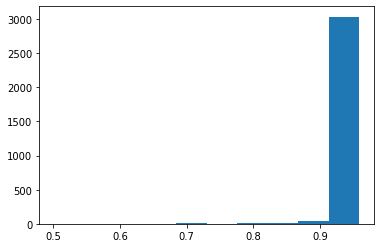

In [ ]:
# w/ Label Smoothing
plt.hist(smoothed_logits[smoothed_corrected].softmax(1).max(1).values)

(array([2.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 5.000e+00,
        4.000e+00, 7.000e+00, 1.000e+01, 3.075e+03]),
 array([0.5275295 , 0.5747716 , 0.6220136 , 0.66925573, 0.7164978 ,
        0.7637399 , 0.810982  , 0.85822403, 0.90546614, 0.9527082 ,
        0.9999503 ], dtype=float32),
 <a list of 10 Patch objects>)

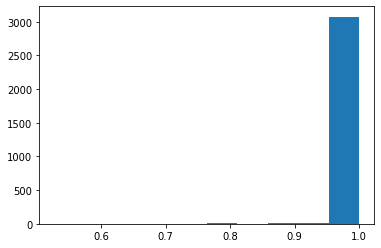

In [ ]:
# w/o Label Smoothing
plt.hist(not_smoothed_logits[not_smoothed_corrected].softmax(1).max(1).values)

(array([ 2.,  3.,  4.,  1.,  2.,  3.,  8.,  4., 10., 25.]),
 array([0.5303809 , 0.572547  , 0.61471313, 0.6568792 , 0.6990453 ,
        0.7412114 , 0.7833775 , 0.82554364, 0.8677097 , 0.9098758 ,
        0.9520419 ], dtype=float32),
 <a list of 10 Patch objects>)

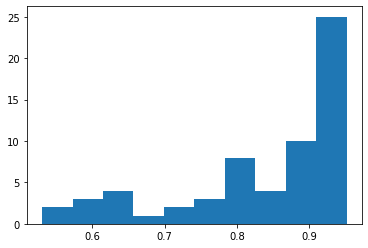

In [ ]:
# w/ Label Smoothing
plt.hist(smoothed_logits[~smoothed_corrected].softmax(1).max(1).values)


(array([ 2.,  1.,  3.,  0.,  3.,  3.,  3.,  2.,  8., 41.]),
 array([0.5030742 , 0.5527611 , 0.60244787, 0.65213466, 0.7018215 ,
        0.75150836, 0.80119514, 0.85088193, 0.9005688 , 0.95025563,
        0.9999424 ], dtype=float32),
 <a list of 10 Patch objects>)

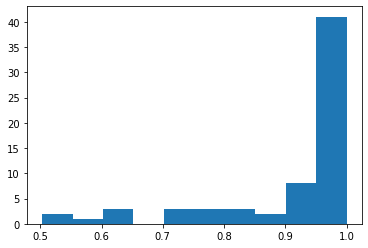

In [ ]:
# w/o Label Smooting

plt.hist(not_smoothed_logits[~not_smoothed_corrected].softmax(1).max(1).values)

In [ ]:
# Inference block

original_test = pd.read_csv("./RawData/test_no_label.csv").rename({"Id" : "sentence"}, axis = "columns")
test_data = utils.get_dataset(original_test, collator, batch_size, False)

inference = []
with tqdm(test_data, unit = " batch") as tepoch :
    model.eval()
    with torch.no_grad() :
        for i, batch in enumerate(tepoch) :
            tepoch.set_description(f"Inference")
            batch = {k : v.to(device) for k, v in batch.items()}
            
            with torch.cuda.amp.autocast():
                outputs = model(**batch)

            logits = outputs["logits"]
            inference += logits.softmax(1).argmax(1).tolist()

original_test.loc[:, "Category"] = inference
original_test = original_test.rename({"sentence" : "Id"}, axis = "columns")
original_test.to_csv("./submission/" + fine_tuned_model_name + ".csv",index = False)